From Internet and my self-experience, I got several kind of cheating.

### Aim Hacks
They will take control of a players aim and automatically target it towards opponents.

### Speed Hacks
They usually give the player a massive speed increase, meaning they can go from one side of the map to the other in seconds.

### Recoil Hacks
automatically manage the recoil. This means all they have to do is press the fire button and don’t have to adjust their mouse to account for the recoil, as the script will do it all for them and every shot will go exactly where they want it to.

### Wall Hacks
Wall hacks basically allow cheaters to see other players through walls, or add extra UI elements to reveal a players location.

Now I have some ideas about cheaters.

* Acquiring 100 weapons without moving
* Killing 100 players without moving
* Run an impossible distnace in a game
...

And I need to find those players who are AFK(Away From Keyboard).

* Killing noone and never moving.

Let's take a look at the actual data.

In [5]:
# For autoreloading modules
#%load_ext autoreload
#%autoreload 2
# For notebook plotting
%matplotlib inline

# Standard libraries
import os
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
#from pdpbox import pdp
#from plotnine import *
#from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor
#from IPython.display import display
pd.set_option('display.max_columns', 50)

In [7]:
train = pd.read_csv('train_V2.csv')

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(19), object(4)
memory usage: 983.9+ MB


In [9]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    #end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [10]:
train = reduce_mem_usage(train)
train.info()

# Check dataframe's shape
print('Shape of training set: ', train.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int8
boosts             int8
damageDealt        float16
DBNOs              int8
headshotKills      int8
heals              int8
killPlace          int8
killPoints         int16
kills              int8
killStreaks        int8
longestKill        float16
matchDuration      int16
matchType          object
maxPlace           int8
numGroups          int8
rankPoints         int16
revives            int8
rideDistance       float16
roadKills          int8
swimDistance       float16
teamKills          int8
vehicleDestroys    int8
walkDistance       float16
weaponsAcquired    int16
winPoints          int16
winPlacePerc       float16
dtypes: float16(6), int16(5), int8(14), object(4)
memory usage: 288.4+ MB
Shape of training set:  (4446966, 29)


# Find the illegal data

In [11]:
# Null data at winPlacePerc
train[train['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,0,0,0,0.0,9,solo-fpp,1,1,1574,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [12]:
train.drop(2744604, inplace=True)

# Find cheater and AFK

## Killing without moving

In [13]:
# Find players who are getting kills without moving.
train['totalDistance'] = train['rideDistance'] + train['walkDistance'] + train['swimDistance']
train['killsWithoutMoving'] = ((train['kills'] > 0) & (train['totalDistance'] == 0))

In [14]:
display(train[train['killsWithoutMoving'] == True].shape)
train[train['killsWithoutMoving'] == True].head(10)

(1535, 31)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,killsWithoutMoving
1824,b538d514ef2476,0eb2ce2f43f9d6,35e7d750e442e2,0,0,593.0000,0,0,3,18,0,6,3,23.546875,593,normal-squad-fpp,15,13,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.856934,0.0,True
6673,6d3a61da07b7cb,2d8119b1544f87,904cecf36217df,2,0,346.5000,0,0,6,33,0,3,1,6.523438,1794,normal-squad-fpp,11,11,1500,0,0.0,0,0.0,0,0,0.0,22,0,0.600098,0.0,True
11892,550398a8f33db7,c3fd0e2abab0af,db6f6d1f0d4904,2,0,1750.0000,0,4,5,3,0,20,6,37.093750,898,normal-solo-fpp,20,15,1500,0,0.0,0,0.0,0,0,0.0,13,0,0.894531,0.0,True
14631,58d690ee461e9d,ea5b6630b33d67,dbf34301df5e53,0,0,157.7500,0,0,0,69,1000,1,1,21.546875,799,normal-squad-fpp,19,18,-1,0,0.0,0,0.0,0,0,0.0,7,1500,0.000000,0.0,True
15591,49b61fc963d632,0f5c5f19d9cc21,904cecf36217df,0,0,100.0000,0,1,0,37,0,1,1,55.437500,1794,normal-squad-fpp,11,11,1500,0,0.0,0,0.0,0,0,0.0,10,0,0.300049,0.0,True
20881,40871bf43ddac7,2cea046b7d1dce,0600f86f11c6e4,0,0,506.0000,4,1,3,7,0,6,2,81.937500,583,normal-squad,6,6,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.799805,0.0,True
23298,b950836d0427da,1f735b1e00d549,ad860f4e162bbc,1,0,1124.0000,0,4,1,7,0,12,5,116.312500,550,normal-squad-fpp,6,6,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.600098,0.0,True
24640,aeced11d46de19,d4009ffa95bb4f,73f3ed869c9171,2,0,530.0000,0,2,11,12,0,7,2,84.375000,599,normal-squad-fpp,15,15,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.856934,0.0,True
25659,6626c4d47cffa0,ee3fe5c0d917c3,341341834b7941,0,1,128.8750,0,1,6,53,1000,2,1,26.984375,732,normal-squad-fpp,8,8,-1,0,0.0,0,0.0,0,0,0.0,12,1500,0.285645,0.0,True
30079,869331b90bfa3f,869ea3ad036e53,fa373e28ff5062,0,0,85.5625,0,0,0,46,0,1,1,16.437500,715,normal-squad-fpp,15,14,1500,0,0.0,0,0.0,0,0,0.0,4,0,0.856934,0.0,True


In [15]:
# Remove outliers
train.drop(train[train['killsWithoutMoving'] == True].index, inplace=True)

## 100% headshots

In [16]:
# Create headshot_rate feature
train['headshot_rate'] = train['headshotKills'] / train['kills']
train['headshot_rate'] = train['headshot_rate'].fillna(0)

In [18]:
train.drop(train[train['headshot_rate']==1].index,inplace = True)

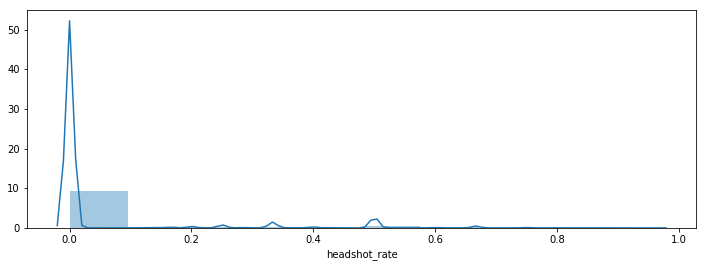

In [19]:
plt.figure(figsize=(12,4))
sns.distplot(train['headshot_rate'], bins=10)
plt.show()

In [13]:
# Players who made a minimum of 10 kills and have a headshot_rate of 100%
display(train[(train['headshot_rate'] == 1) & (train['kills'] > 9)].shape)
train[(train['headshot_rate'] == 1) & (train['kills'] > 9)]

(24, 32)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,killsWithoutMoving,headshot_rate
281570,ab9d7168570927,add05ebde0214c,e016a873339c7b,2,3,1212.0,8,10,0,1,...,0.00,0,0,2940.0,5,0,0.846191,2940.0,False,1.0
346124,044d18fc42fc75,fc1dbc2df6a887,628107d4c41084,3,5,1620.0,13,11,3,1,...,0.00,0,0,3422.0,8,1560,1.000000,8144.0,False,1.0
871244,e668a25f5488e3,5ba8feabfb2a23,f6e6581e03ba4f,0,4,1365.0,9,13,0,1,...,0.00,0,0,2104.0,5,1587,1.000000,2104.0,False,1.0
908815,566d8218b705aa,a9b056478d71b2,3a41552d553583,2,5,1535.0,10,10,3,1,...,0.00,2,0,2760.0,7,1519,0.962891,7948.0,False,1.0
963463,1bd6fd288df4f0,90584ffa22fe15,ba2de992ec7bb8,2,6,1355.0,12,10,2,1,...,0.00,0,0,2458.0,4,1562,1.000000,3476.0,False,1.0
1079403,1c245ed99b5f96,e42d09a9b8463a,5cec236bce68eb,0,5,1218.0,8,11,3,1,...,0.00,0,0,2932.0,4,0,1.000000,8180.0,False,1.0
1167959,c4f80d4be5c561,b4a7892189b5dd,c7f7733ebbd447,0,4,1065.0,6,10,1,1,...,0.00,0,0,2450.0,7,1468,1.000000,2860.0,False,1.0
1348164,474a641f0a4bcb,2fdad3ca6fb3c0,114499c82f35d7,1,5,1319.0,11,12,1,1,...,0.00,0,0,3916.0,5,0,1.000000,5964.0,False,1.0
1380385,202ce6a55119c5,2df66861f597b4,496700c29a5d44,1,4,1150.0,4,11,1,1,...,0.00,0,0,3108.0,7,1500,1.000000,3108.0,False,1.0
1483199,9d483f7cbb34d4,db5867bc814191,69495e3c478eb9,0,10,1478.0,8,13,2,1,...,140.75,0,0,2340.0,4,0,1.000000,2480.0,False,1.0


In [14]:
# Remove outliers
#train.drop(train[(train['headshot_rate'] == 1) & (train['kills'] > 9)].index, inplace=True)

# Longest kill

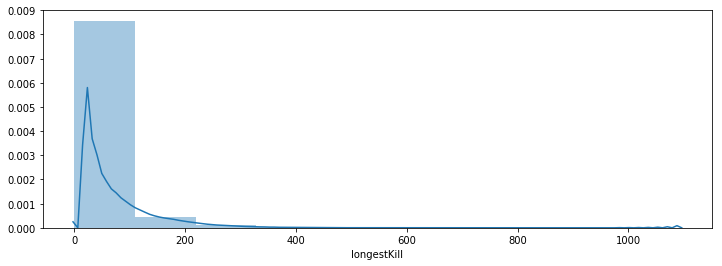

In [7]:
plt.figure(figsize=(12,4))
sns.distplot(train['longestKill'], bins=10)
plt.show()

In [13]:
display(train[train['longestKill'] >= 1000].shape)
train[train['longestKill'] >= 1000]

(24, 29)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
195021,f141f7e776138b,a0fa42bf37e9f0,0b4c9543bc9199,1,4,784.00,5,4,5,4,1195,4,2,1000.0,2190,duo,34,31,-1,0,6248.000,0,0.0000,0,0,3678.000000,5,1523,0.848633
202281,88e2af7d78af5a,34ddeede52c042,4346bc63bc67fa,0,3,784.00,5,1,1,5,0,4,3,1000.0,1864,squad,27,27,1482,0,723.000,0,0.0000,0,1,3052.000000,9,0,0.923340
240005,41c2f5c0699807,9faecf87ab4275,634edab75860b3,5,0,1284.00,8,5,7,18,1000,11,2,1004.0,1308,normal-duo-fpp,14,13,-1,1,0.000,0,0.0000,0,0,48.875000,38,1500,0.538574
324313,ef390c152bcc3d,30fd444be3bbc1,4f7f8d6cf558b4,2,0,1028.00,0,0,0,9,0,10,2,1026.0,698,normal-squad-fpp,13,13,1500,0,1717.000,0,0.0000,0,0,1264.000000,26,0,1.000000
523088,1ff9763ca30279,7fb3a83ebb050d,838cb9a3c94598,0,0,151.25,0,0,0,45,0,1,1,1081.0,1195,normal-squad-fpp,8,8,1500,0,0.000,0,0.0000,0,0,0.000000,3,0,0.714355
656553,9948b058562163,c8cb8491112bf6,0104eeb664494d,6,0,1410.00,17,5,0,3,1000,16,4,1000.0,1091,normal-squad-fpp,6,6,-1,4,0.000,0,0.0000,0,0,29.203125,30,1500,0.600098
803632,4e7e6c74e3c57d,94698690918933,da91b0c3d875f8,0,0,196.75,0,0,0,51,0,1,1,1075.0,471,normal-squad-fpp,8,8,1500,0,2084.000,0,0.0000,0,0,1074.000000,22,0,0.000000
895411,1f5ba6e0cfb968,512ea24b831be3,5fb0d8b1fc16cf,4,0,1012.00,11,5,0,5,0,10,3,1094.0,1021,normal-squad-fpp,12,12,1500,0,0.000,0,0.0000,0,0,569.500000,18,0,0.909180
996713,f4082eee4c45e9,4d02ce950f74fc,838cb9a3c94598,1,0,916.50,0,0,0,17,0,10,2,1072.0,1195,normal-squad-fpp,8,8,1500,0,0.000,0,0.0000,4,0,0.000000,15,0,1.000000
1172437,303a93cfa1f46c,8795d39fd0df86,9c8962b58bb3e3,2,1,329.25,0,0,2,45,1000,3,1,1037.0,581,normal-squad-fpp,8,7,-1,0,0.000,0,0.0000,0,0,832.500000,9,1500,0.285645


In [17]:
train[train['longestKill']==max(train['longestKill'])]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
895411,1f5ba6e0cfb968,512ea24b831be3,5fb0d8b1fc16cf,4,0,1012.0,11,5,0,5,0,10,3,1094.0,1021,normal-squad-fpp,12,12,1500,0,0.0,0,0.0,0,0,569.5,18,0,0.90918


Longest kill are around 1000 meters, which is still reasonable if they are using a 8x scope with a sniper rifle. We need to check their weapons and accessories. 

## Ride distance

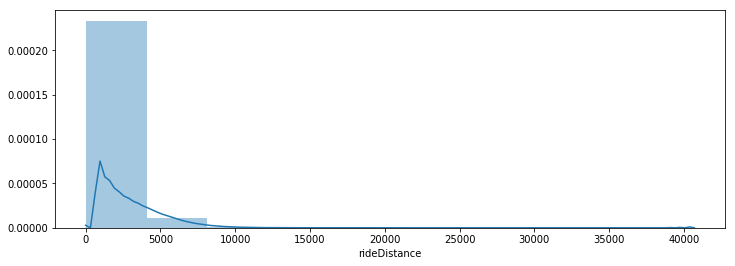

In [14]:
plt.figure(figsize=(12,4))
sns.distplot(train['rideDistance'], bins=10)
plt.show()

In [33]:
display(train[train['rideDistance'] >= 30000].shape)
train[train['rideDistance'] >= 30000]

(17, 29)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
426708,149e224a2330ae,6d8cb80b3de8ff,f8b8e2643f60ee,0,2,0.000000,0,0,2,43,1120,0,0,0.000000,2007,solo,83,83,-1,0,31968.0,0,0.000,0,0,402.000000,3,1449,0.816895
605623,8dee54600c67ca,e77f3e175b5959,26bc606cdae6bf,0,0,11.210938,0,0,0,27,1179,0,0,0.000000,1851,solo,51,50,-1,0,33984.0,0,0.000,0,0,1641.000000,0,1498,0.680176
1214637,470dca70fbef4d,d44161e5d29c1a,c7d52d5aaff270,0,0,127.312500,0,0,8,24,0,1,1,6.300781,1855,solo-fpp,95,92,1541,0,31968.0,1,0.000,0,0,642.000000,1,0,0.978516
1232004,2c5add87b29a8c,1d9d7faa352311,ef2ae297b170f3,0,7,196.875000,0,0,4,24,1517,1,1,85.437500,1862,solo-fpp,98,96,-1,0,30032.0,0,53.375,0,0,1328.000000,2,1565,0.886719
1232362,4bf27787223351,b0140dd17f3238,5ed9c405f7e71d,0,1,0.000000,0,0,10,47,0,0,0,0.000000,1896,solo,95,91,1501,0,31008.0,0,0.000,1,0,1473.000000,3,0,0.797852
1361247,f09d0c99127850,4ca387960d74a7,93aa204e9c193e,0,2,265.500000,0,0,4,10,1568,2,1,26.687500,1804,solo-fpp,92,88,-1,0,35392.0,0,0.000,0,0,1912.000000,7,1538,1.000000
1713773,239905dd1f3787,da3d922a92ace5,692bd6a11b86c8,0,0,141.250000,0,0,1,21,1216,1,1,87.687500,1719,solo-fpp,96,93,-1,0,31504.0,0,0.000,0,0,448.250000,3,1537,0.947266
1725337,9f14f77b6dd9b6,8a2a8ae2506323,904b5fa7f59bc5,0,2,2.388672,0,0,5,19,1193,0,0,0.000000,1918,solo-fpp,37,35,-1,0,37664.0,0,0.000,0,0,542.000000,2,1565,0.694336
2137063,73b793b4e7523f,f4444641af7e5c,6385f7641268c3,0,0,0.000000,0,0,0,52,0,0,0,0.000000,1794,solo-fpp,94,92,1512,0,31376.0,0,0.000,0,0,28.765625,0,0,0.720215
2700691,3428324a089608,fa77b4ac736dbf,9b1c87f4016f47,0,1,31.265625,0,0,0,46,1211,0,0,0.000000,1886,solo-fpp,98,95,-1,0,31296.0,0,0.000,0,0,174.125000,1,1530,0.855469


## Swim distance

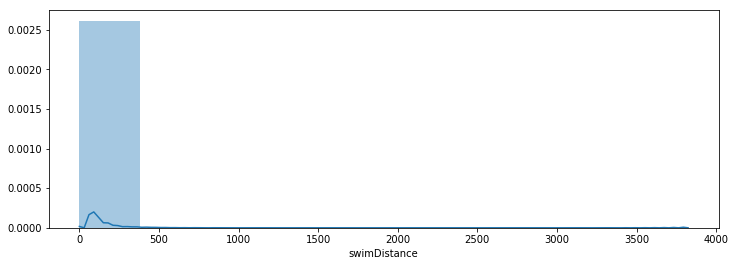

In [28]:
plt.figure(figsize=(12,4))
sns.distplot(train['swimDistance'], bins=10)
plt.show()

In [30]:
display(train[train['swimDistance'] >= 2000].shape)
train[train['swimDistance'] >= 2000]

(12, 29)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
177973,c2e9e5631f4e54,23213058f83abe,f01eb1073ef377,0,5,78.12500,1,0,1,47,1058,0,0,0.000000,1399,duo-fpp,50,46,-1,0,0.0,0,2296.0,0,0,1002.000000,4,1466,0.958984
274258,ba5e3dfb5a0fa0,383db055216ec2,d6e13468e28ab4,0,4,53.31250,0,0,16,39,0,0,0,0.000000,2188,squad,26,25,1584,0,5688.0,0,2148.0,0,0,2276.000000,5,0,0.959961
1005337,d50c9d0e65fe2a,4996575c11abcb,668402592429f8,0,1,503.00000,4,3,1,6,1103,3,1,868.500000,1897,squad,26,25,-1,0,3332.0,0,2718.0,0,0,4692.000000,5,1516,1.000000
1195818,f811de9de80b70,d08ddf7beb6252,8a48703ab52ec8,0,7,352.25000,3,1,6,4,1039,5,1,64.500000,1396,duo-fpp,49,48,-1,0,0.0,0,2668.0,0,0,415.000000,10,1499,1.000000
1227362,a33e917875c80e,5b72674b42712b,5fb0d8b1fc16cf,0,1,589.00000,3,1,1,46,0,2,1,48.218750,1021,normal-squad-fpp,12,12,1500,0,0.0,0,3824.0,0,0,995.500000,9,0,1.000000
1889163,bd8cc3083a9923,1d5d17140d6fa4,8e2e6022d6e5c8,0,0,0.00000,0,0,0,47,0,0,0,0.000000,1387,squad-fpp,25,23,1327,0,864.0,0,2484.0,0,0,1966.000000,3,0,0.583496
2065940,312ccbb27b99aa,47c7f4d69e2fb1,b4b11756321f3a,1,3,49.59375,0,0,5,48,1097,0,0,0.000000,1379,duo-fpp,48,46,0,1,2088.0,0,3514.0,0,0,4296.000000,8,1492,0.851074
2327586,8773d0687c6aae,b17f46f9f6666c,56ee5897512c86,3,1,474.50000,2,0,0,7,0,3,2,30.015625,1210,squad-fpp,27,24,1516,0,0.0,0,2388.0,0,0,7.546875,6,0,1.000000
2784855,a8653b87e83892,383db055216ec2,d6e13468e28ab4,1,4,844.00000,5,5,2,2,0,7,1,697.000000,2188,squad,26,25,1628,1,3032.0,0,2206.0,0,0,4688.000000,4,0,0.959961
3359439,3713b36e1ba9e1,1f7aed9240864a,584447ed875c85,0,0,0.00000,0,0,0,77,1056,0,0,0.000000,1372,squad-fpp,29,29,-1,0,0.0,0,2338.0,0,0,1750.000000,0,1518,0.214355


## Walk distance

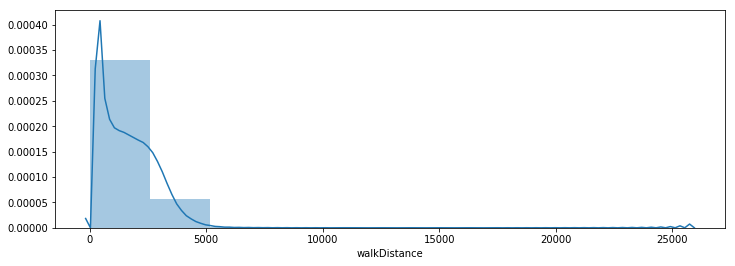

In [19]:
plt.figure(figsize=(12,4))
sns.distplot(train['walkDistance'], bins=10)
plt.show()

In [22]:
# walkDistance anomalies
# From offical document, we know the fastest running speed(Standing Sprint) is 6.3m/s, which means the max walk distanceis 6.3*30*60=11340m
display(train[train['walkDistance'] >= 11340].shape)
train[train['walkDistance'] >= 11340].head(10)

(73, 29)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
23026,8a6562381dd83f,23e638cd6eaf77,b0a804a610e9b0,0,1,0.00000,0,0,0,44,0,0,0,0.000000,1906,solo,99,93,1517,0,0.421143,0,9.882812,0,0,13528.0,7,0,0.816406
49312,582685f487f0b4,338112cd12f1e7,d0afbf5c3a6dc9,0,4,117.18750,1,0,1,24,0,1,1,6.824219,2192,duo-fpp,47,46,1507,0,0.008797,0,36.750000,0,0,12408.0,3,0,0.913086
68590,8c0d9dd0b4463c,c963553dc937e9,926681ea721a47,0,1,32.34375,0,0,1,46,1378,0,0,0.000000,1836,duo-fpp,49,47,-1,0,848.000000,0,45.812500,0,0,11592.0,3,1563,0.833496
125103,db5a0cdc969dcb,50cc466757950e,c306a9745c4c1d,0,4,37.71875,0,0,7,47,1000,0,0,0.000000,1957,solo,95,93,-1,0,0.037811,0,38.750000,0,0,12792.0,5,1500,0.733887
497965,3304d0c68e27f5,503757159d22dd,ce88f9c8c35bdf,0,0,0.00000,0,0,0,46,0,0,0,0.000000,1889,solo-fpp,95,93,1520,0,0.007801,0,382.000000,0,0,25776.0,0,0,0.989258
662447,25376a4331b10b,4e629d92603b40,686414143eede7,0,3,0.00000,0,0,5,42,0,0,0,0.000000,1961,solo,95,91,1511,0,0.001900,0,128.750000,0,0,12120.0,8,0,0.840332
663013,0094b44ec49851,136caccc9e5f3e,a9613a88fb7a12,0,7,67.18750,0,0,8,22,0,0,0,0.000000,1798,squad-fpp,18,17,1521,0,2396.000000,0,53.218750,0,0,11792.0,4,0,0.882324
676764,cc4d6a8f737cc6,d0575079637b8b,3fd5034a237ae6,0,0,0.00000,0,0,2,44,1018,0,0,0.000000,1898,solo-fpp,96,93,-1,0,210.000000,0,29.546875,0,0,11664.0,2,1510,0.789551
701405,1d3497f7c5082a,46d54051b40e04,a1646b69b4d5be,0,3,0.00000,0,0,2,42,0,0,0,0.000000,1941,duo-fpp,47,44,1535,0,0.011101,0,25.921875,0,0,11584.0,6,0,0.934570
743018,8396ee83842b40,cbcc59f77ee932,0a8cb598a06c18,0,1,0.00000,0,0,4,43,0,0,0,0.000000,1836,duo-fpp,49,46,1483,0,2434.000000,0,30.531250,0,0,11512.0,11,0,0.854004


In [46]:
train.drop(train[train['walkDistance'] >= 11340].index, inplace=True)

## Over all moving distance.

In [36]:
train["moveDistance"] = train["walkDistance"] + train["swimDistance"] + train["rideDistance"]

In [42]:
print("The longest move distance is %sm;\nThe longest walk distance is %sm;\n\
The longest swim distance is %sm;\nThe longest ride distance is %sm; "%(max(train['moveDistance']), max(train['walkDistance']), max(train['swimDistance']), max(train['rideDistance'])))

The longest move distance is 41280.0m;
The longest walk distance is 25776.0m;
The longest swim distance is 3824.0m;
The longest ride distance is 40704.0m; 


## Weapons acquired

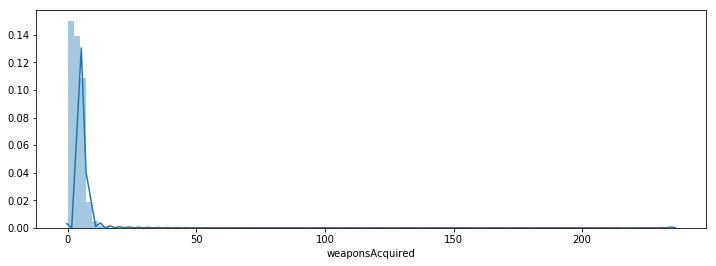

In [24]:
plt.figure(figsize=(12,4))
sns.distplot(train['weaponsAcquired'], bins=100)
plt.show()

In [45]:
display(train[train['weaponsAcquired'] >= 50].shape)
train[train['weaponsAcquired'] >= 50].head()

(178, 30)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,moveDistance
42857,93ed29a0b51966,b4583304a6b039,e024bf51bf1799,5,0,1564.0,0,3,2,15,0,14,2,100.3125,1798,normal-solo-fpp,19,18,1500,0,1315.0,0,0.0,0,0,1173.0000,50,0,0.222168,2488.0000
50279,fede4e068062fb,899307b1010c21,a9e84c456cc859,3,0,1691.0,0,3,7,6,0,19,2,48.3125,1795,normal-solo-fpp,13,10,1500,0,0.0,0,0.0,0,0,165.2500,52,0,0.666504,165.2500
88852,b45b70a8d261e5,894d0860012ee1,17dea22cefe62a,8,0,1551.0,0,2,6,18,0,14,2,91.5625,1798,normal-duo-fpp,15,12,1500,0,0.0,0,0.0,0,0,26.0625,61,0,0.285645,26.0625
100009,6960550b7f37b2,65bcc1e5d4f168,17dea22cefe62a,7,0,2028.0,0,5,6,15,0,18,2,90.2500,1798,normal-duo-fpp,15,12,1500,0,0.0,0,0.0,0,0,274.5000,63,0,0.571289,274.5000
104825,4fe1c1b84d0e4c,62bc19a85c2ed8,17dea22cefe62a,3,0,2652.0,0,3,3,9,0,24,3,31.0000,1798,normal-duo-fpp,15,12,1500,0,3620.0,0,0.0,0,0,1024.0000,71,0,0.928711,4644.0000


In [47]:
train.drop(train[train['weaponsAcquired'] >= 50].index, inplace=True)

## Find AFK

In [44]:
display(train[(train['moveDistance'] == 0) & (train["damageDealt"] == 0)].shape)

(88205, 30)

In [48]:
train.drop(train[(train['moveDistance'] == 0) & (train["damageDealt"] == 0)].index, inplace=True)

# Data after preprocessing

In [49]:
display(train.shape)

(4358510, 30)

In [50]:
train.to_csv('../.././data/pubg_kaggle/train_after_prepo.csv')